In [1]:
import sys
main_dir = '../'
sys.path.append(main_dir)

import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.signal import hilbert
from scipy.linalg import inv, cho_solve, cho_factor, solve_toeplitz, toeplitz
import scipy.ndimage as sn

import tqdm
from functools import lru_cache

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

import concurrent.futures

import qutip as qu
from qutip import piqs
from qutip import correlation

import opennu as on

plt.style.use(main_dir+'sty.mplstyle')

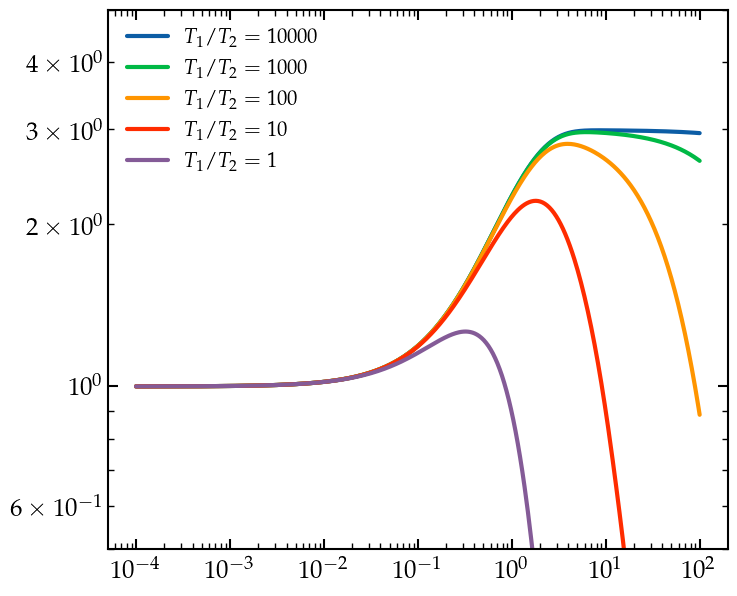

In [6]:
N = 1e8
for gg in [1e-4, 1e-3, 1e-2, 0.1, 1]:
    t, j0, s0, = on.solve(N, p_init=1, gp_ratio=0.99, tf=1e2, ti=1e-4, gd_ratio=N, gl_ratio=gg*N, ntimes=500)
    sig = s0**2/(N/4)
    plt.loglog(t, sig, label=r'$T_1/T_2=%d$'%(1/gg))
plt.legend()
plt.ylim(0.5, 5)
plt.show()

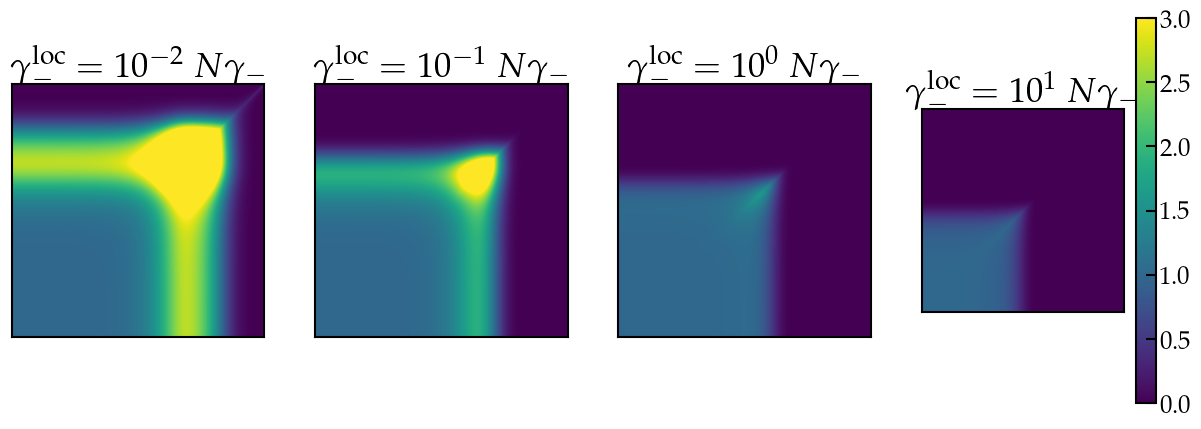

In [7]:
N = 1e3


gl = [0.01, 0.1, 1, 10]

fig, ax = plt.subplots(1,len(gl), figsize=(15,5))
                       
for i in range(len(gl)):
    gamma = gl[i]
    glr = gl[i]
    t, j0, s0, = on.solve(N, p_init=1, gp_ratio=0.99, tf=1e3, ti=1e-5, gd_ratio=N, gl_ratio=glr*N, ntimes=int(1e3))
    sig = s0**2/(N/4)
    tdiff = np.abs(t[:, None] - t[None, :])
    corr = np.exp(-glr* tdiff)
    sigma_outer = np.outer(sig, sig)
    cov = sigma_outer * corr
    im = ax[i].imshow(cov, vmin=0, vmax=3, origin='lower')
    ax[i].set_title(r'$\gamma_-^{\rm loc}=10^{%d}~N\gamma_-$'%np.log10(gl[i]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.colorbar(im)

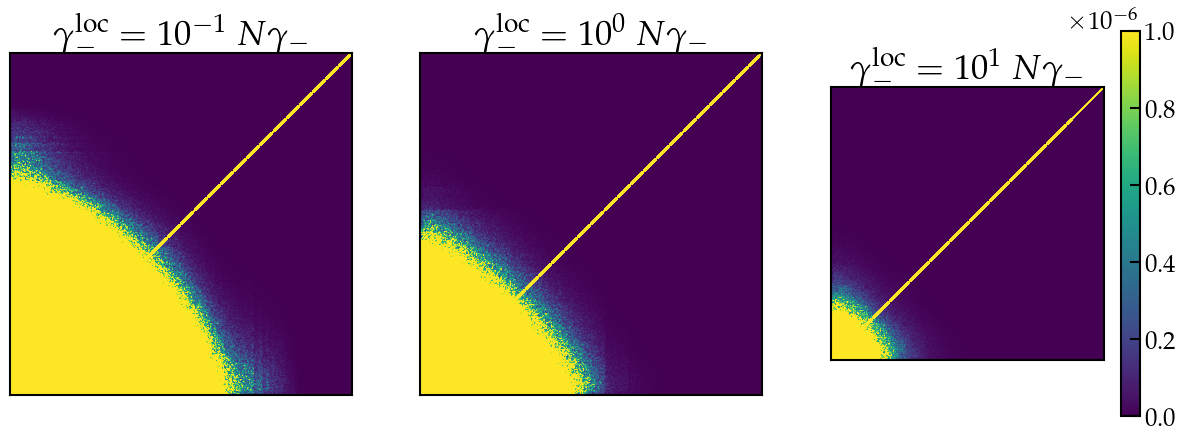

In [8]:
N = 1e3

fig, ax = plt.subplots(1,3,figsize=(15,5))
gl = [0.1, 1, 10]
                       
for i in range(3):
    gamma = gl[i]
    glr = gl[i]
    t, j0, s0, = on.solve(N, p_init=1, gp_ratio=0.99, tf=1e3, ti=1e-5, gd_ratio=N, gl_ratio=glr*N, ntimes=int(1e3))
    sig = s0**2/(N/4)
    tdiff = np.abs(t[:, None] - t[None, :])
    corr = np.exp(-glr* tdiff)
    sigma_outer = np.outer(sig, sig)
    cov = sigma_outer * corr
    ide = np.eye(len(cov))
    C_inv = cho_solve(cho_factor(cov), ide)
    im = ax[i].imshow(np.abs(C_inv), vmax=0.000001, origin='lower')
    ax[i].set_title(r'$\gamma_-^{\rm loc}=10^{%d}~N\gamma_-$'%np.log10(gl[i]))
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.colorbar(im)

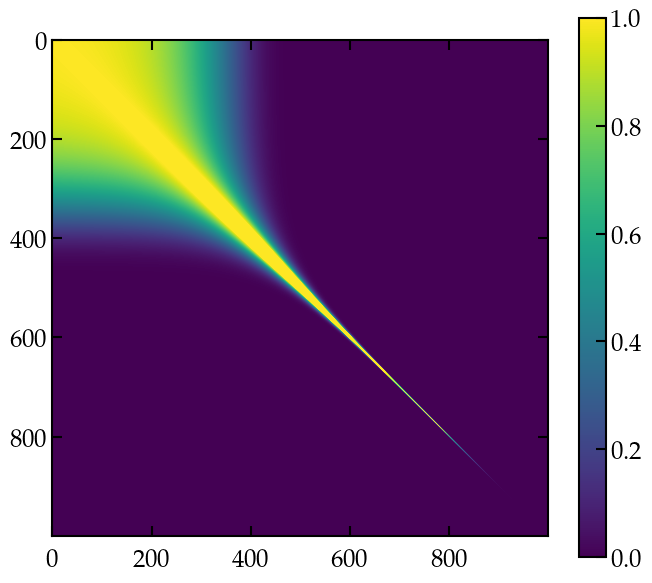

In [9]:
N = 1e8

t, j0, s0, = on.solve(N, p_init=1, gp_ratio=0.99, tf=1e3, ti=1e-3, gd_ratio=N, gl_ratio=0.01*N, ntimes=int(1e3))
sig = s0**2/(N/4)




tdiff = np.abs(t[:, None] - t[None, :])
gamma = 10
corr = np.exp(-gamma * tdiff)
sigma_outer = np.outer(sig, sig)
cov = sigma_outer * corr
ide = np.eye(len(cov))
C_inv2 = cho_solve(cho_factor(cov), ide)

plt.imshow(cov, vmin=0, vmax=1)
plt.colorbar()

In [10]:
%%time
C_inv1 = inv(cov)

CPU times: user 13.6 s, sys: 11 ms, total: 13.6 s
Wall time: 714 ms


In [11]:
%%time
ide = np.eye(len(cov))
C_inv2 = cho_solve(cho_factor(cov), ide)

CPU times: user 2.88 s, sys: 90 µs, total: 2.88 s
Wall time: 150 ms


In [35]:
gm = 0.1
gp = 0.995*gm

a = (gm-gp)/(gm+gp)
b = (1-gp/gm)/(1+gp/gm)
print(a)
print(b)

0.002506265664160403
0.002506265664160403


In [5]:
def find_delta_Cho_tmp(
        R,
        mnu,
        p_init=1,
        sampf=14.3e3,
        B=0.1,
        T2=1,
        T1ratio=10,
        gpr_local=0.995,
        Nshots=100,
        seed=42,
        d_init=1e5,
        d_fin=1e20,
        ndelta=100,
        chi2_crit=2.7,
        squid_noise_ratio=0.0,
        ncode=1e3,
        Bmax=12,
        mode='m1',
        sample='Xe',
        squeeze=1,
        opt=True,
        sigma_spn=False,
        verb=False
    ):
    '''
    Chi-squared analysis on normalized ⟨J_z⟩, starting from
    equatorial product state assuming T1 >> T2.
    Returns upper limit on delta at specified confidence level.
    '''

    if sample == 'Xe':
        ns = 1.35e22
        gy = 11.78e6
    elif sample == 'He':
        ns = 3e22
        gy = 32.43e6
    elif sample == 'H':
        ns = 3e22
        gy = 42.58e6
    else:
        raise ValueError("Sample not valid, choose 'Xe', 'He' or 'H'!")
    eVHz = 1 / 6.58e-16 # eV/Hz conversion
    w0 = 2 * np.pi * gy * B / eVHz # eV
    pnu = 5.3e-4*2*np.pi*8065 # cm^-1
    N = ns * 4 * np.pi / 3 * R**3 # number of spins
    fsup = max(1, 4*(pnu * R)**2) # coherent suppression factor
    w0_i = w0

    # --- Time grid ---
    tf = T2
    ti = 1 / sampf
    n_times = int((tf - ti) * sampf)
    t_exp = np.linspace(ti, tf, n_times)

    # --- Gamma ratios ---
    gratio, gm, mm = on.compute_ratio(mnu, w0, mode=mode)
    if verb:
        print("At B=%.2f, I get w=%.3e"%(B, w0))
        print("g+/g- = %.7f"%gratio)
    # --- Optimal splitting and B-field limitations
    if opt:
        knu = 5.3e-4
        m1 = mm[0]
        w0_opt = knu/m1/R/(8065*2*np.pi)
        if w0_opt < w0:
            if verb:
                print("Warning: splitting too large, adjusting to optimal value!")
        w0 = w0_opt
        B_opt = w0_opt * eVHz / (2*np.pi * gy)
        if B_opt > Bmax:
            if verb:
                print("Optimal splitting needs too large B field, adjusting to Bmax!")
            B = Bmax
            w0 = 2 * np.pi * gy * B / eVHz
        gratio, gm, mm = on.compute_ratio(mnu, w0, mode=mode)
        if verb:
            print("Passed w=%.3e, optimal w=%.3e, used w=%.3e"%(w0_i, w0_opt, w0))
            print("g+/g- = %.7f"%gratio)
    if verb:
        print("Max rate is Gamma_-= %.3e Hz"%(gm*N**2/fsup))


    # --- Memoized model prediction for normalized ⟨J_z⟩ ---
    @lru_cache(maxsize=64)
    def get_model_jz(delta):
        Ncode = int(ncode)
        tmin_code = min(t_exp) * N * gm/fsup * delta
        tmax_code = max(t_exp) * N * gm/fsup * delta
        t, jz, sz = on.solve(
            Ncode,
            gp_ratio=gratio,
            gd_ratio=Ncode,
            gml_ratio=1/T1ratio*Ncode, 
            gpl_ratio=gpr_local/T1ratio*Ncode, 
            p_init=p_init,
            ti=tmin_code,
            tf=tmax_code,
            ntimes=n_times,
            tlin=True
        )
        jz_norm = jz / (Ncode / 2)
        sz_norm = sz/ ( Ncode**(1/2) / 2)
        return t, np.abs(jz_norm), sz_norm

    @lru_cache(maxsize=64)
    def get_model_jz_bkg(delta):
        Ncode = int(ncode)
        tmin_code = min(t_exp) * N * gm/fsup * delta
        tmax_code = max(t_exp) * N * gm/fsup * delta
        t, jz, sz = on.solve(
            Ncode,
            gp_ratio=gratio,
            gd_ratio=Ncode,
            gml_ratio=1/T1ratio*Ncode, 
            gpl_ratio=gpr_local/T1ratio*Ncode, 
            p_init=p_init,
            ti=tmin_code,
            tf=tmax_code,
            ntimes=n_times,
            nu_off=True,
            tlin=True
        )
        jz_norm = jz / (Ncode / 2)
        return t, np.abs(jz_norm)

    delta_list = np.geomspace(d_init, d_fin, ndelta)
    chi2_min = np.inf
    delta_best = None
    delta_crit = None
    chi2l = []

    for delta in delta_list:
        _, jz_pred, sz_pred = get_model_jz(delta)
        _, jz_bkg = get_model_jz_bkg(delta)
        if sigma_spn:
            sz_pred = np.ones_like(sz_pred)
        d = jz_pred - jz_bkg
        norm_factor = N / 4.0
        sigma = sz_pred / np.sqrt(norm_factor)
        gamma_loc = 2.0 / T1ratio / T2
        delta_t = np.abs(t_exp[:, np.newaxis] - t_exp[np.newaxis, :])
        corr = np.exp(-gamma_loc * delta_t)
        C = (sigma[:, np.newaxis] * sigma[np.newaxis, :] * corr) / squeeze ** 2
        if squid_noise_ratio > 0.0:
            noise_term = squid_noise_ratio / norm_factor
            C += np.eye(n_times) * noise_term
        chole = cho_factor(C)
        x = cho_solve(chole, d)
        chi2 = Nshots * np.dot(d, x)
        chi2l.append(chi2)
        if chi2 < chi2_min:
            chi2_min = chi2
            delta_best = delta
        if delta_crit is None and chi2 - chi2_min > chi2_crit:
            delta_crit = delta
            break
    if delta_crit is None:
       print("No delta found within scan range for J_z")
    return delta_crit, chi2l, chi2-chi2_min, w0

In [17]:
delta, c2l, _, _ = on.find_delta_Cho(10,0.1, T2=1, Nshots=100, sampf=100, squid_noise_ratio=0.0, T1ratio=1000, 
                                     mode='m1',sample='He',opt=True, d_init=1e8,d_fin=1e19)
print("%.3e"%delta)

3.594e+14


In [21]:
delta, c2l, _, _ = find_delta_Cho_tmp(10,0.1, T2=1, Nshots=100, sampf=10, squid_noise_ratio=0.0, T1ratio=1000, mode='m1',sample='Xe',opt=True, 
                                  verb=False, d_init=1e8,d_fin=1e19)
print("%.3e"%delta)

1.292e+15


In [4]:
dell1 = []
dell2 = []
dell3 = []

t2l = np.geomspace(10, 1000, 50)
for t2 in tqdm.tqdm(t2l):
    
    delta, c2l, _, _ = on.find_delta_Cho(1, 0.1, T2=t2, Nshots=100, sampf=1, squid_noise_ratio=0.0,T1ratio=100, mode='m1',sample='Xe',opt=True, 
                                      verb=False, d_init=1e9,d_fin=1e21)
    dell1.append(delta)
    delta, c2l, _, _ = on.find_delta_Cho(1, 0.1, T2=t2, Nshots=100, sampf=1, squid_noise_ratio=0.0,T1ratio=10, mode='m1',sample='Xe',opt=True, 
                                      verb=False, d_init=1e9,d_fin=1e21)
    dell2.append(delta)
    delta, c2l, _, _ = on.find_delta_Cho(1, 0.1, T2=t2, Nshots=100, sampf=1, squid_noise_ratio=50.0,T1ratio=100, mode='m1',sample='Xe',opt=True, 
                                      verb=False, d_init=1e9,d_fin=1e21)
    dell3.append(delta)

dell1 = np.array(dell1)
dell2 = np.array(dell2)
dell2 = np.array(dell2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  3.16s/it]


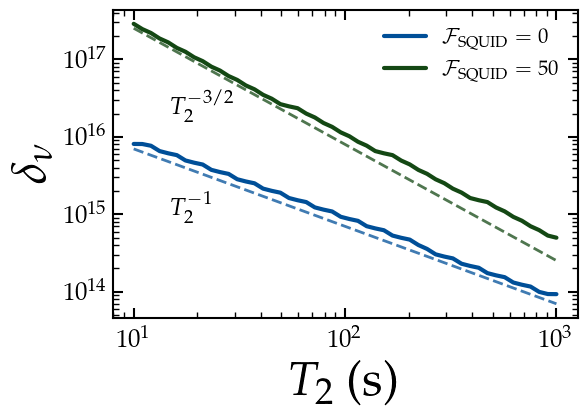

In [20]:
fig, ax = plt.subplots(figsize=(6,4))

plt.loglog(t2l, sn.gaussian_filter(dell1, sigma=0.7), label=r'${\cal F}_{\rm SQUID}=0$',  c='#004f98', lw=3) 
plt.loglog(t2l, sn.gaussian_filter(dell3, sigma=0.7), label=r'${\cal F}_{\rm SQUID}=50$', c='#144814', lw=3) 

norm1 = 7e16
norm2 = 0.8e19

plt.loglog(t2l, norm1*t2l**(-1),  c='#004f98', ls='--', alpha=0.75, lw=2) 
plt.loglog(t2l, norm2*t2l**(-3/2),  c='#144814', ls='--', alpha=0.75, lw=2) 

plt.text(15,1e15,r'$T_2^{-1}$', fontsize=18)
plt.text(15,2e16,r'$T_2^{-3/2}$', fontsize=18)

plt.xlabel(r'$T_2$ (s)')
plt.ylabel(r'$\delta_\nu$')

plt.legend()
plt.show()
fig.savefig(main_dir+'plots/T2_scaling.pdf', bbox_inches='tight')

## $R$ dependence

In [21]:
rl = np.geomspace(0.005, 10, 100)

def worker(r):
    de, _, _, wu  = on.find_delta_Cho(r, 0.05, p_init=1, sampf=1, T2=10, Nshots=10, seed=42,
                              d_init=1e11, d_fin=1e30, ndelta=200, B=0.1, opt=True)
    de2, _, _, wu2 = on.find_delta_Cho(r, 0.05, p_init=1, sampf=1, T2=10, Nshots=10, seed=23,
                              d_init=1e11, d_fin=1e30, ndelta=200, B=0.1, opt=False)
    return de, de2, wu, wu2

dell_r = []
dell_r2 = []
wl = []
wl2 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = list(tqdm.tqdm(executor.map(worker, rl), total=len(rl)))

dell_r, dell_r2, wl, wl2 = zip(*results)
dell_r = np.array(dell_r)
dell_r2 = np.array(dell_r2)
wl= np.array(wl)
wl2 = np.array(wl2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.59it/s]


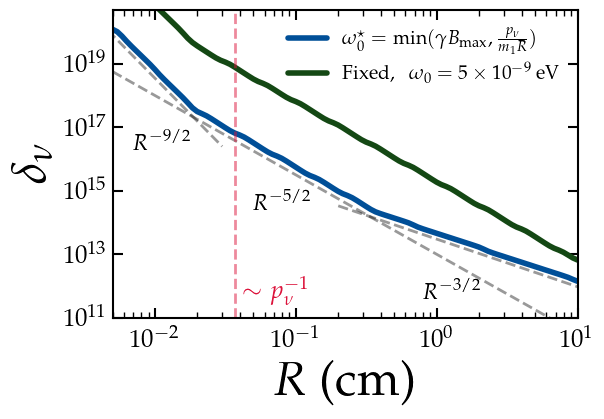

In [38]:
ss = 1

norm = 100**(1)*10

r1 = np.geomspace(0.001, 0.03, 30)
r2 = np.geomspace(0.05, 10, 30)
r3 = np.geomspace(0.1, 10, 30)
r4 = np.geomspace(0.2, 10, 30)

fig, ax = plt.subplots(figsize=(6,4))

ax.loglog(rl, sn.gaussian_filter(dell_r/norm, sigma=ss), label=r'$\omega^\star_0=\min(\gamma B_{\rm max}, \frac{p_{\nu}}{m_1 R})$', c='#004f98', lw=4)
ax.loglog(rl, sn.gaussian_filter(dell_r2/norm, sigma=ss), label=r'Fixed, ~~$\omega_0=5\times 10^{-9}$ eV', c='#144814',lw=4)



ck = 'k'
ax.loglog(rl, rl/rl*1e11, c=ck, lw=1, ls='dashdot', zorder=0)
lw1 = 2
alp = 0.4
ax.loglog(r1, 3.5e9*r1**(-9/2),  ls='--', c='k', lw=lw1, alpha=alp)
ax.loglog(rl, 1e13*rl**(-5/2), ls='--', c='k', lw=lw1, alpha=alp)
#ax0.loglog(r1, 7e4*r1**(-9/2),  ls='--', c='k', lw=lw1, alpha=alp)
#ax0.loglog(rl, 1.8e8*rl**(-5/2), ls='--', c='k', lw=lw1, alpha=alp)
ax.loglog(r4, 3e13*r4**(-3/2),  ls='--', c='k', lw=lw1, alpha=alp)
ax.axvline(1/27, alpha=0.5, lw=2, c='crimson', ls='--')
ax.text(0.042, 4e11, r'$\sim p^{-1}_\nu$', c='crimson', fontsize=18)

ttfs = 16

#ax.text(7e-3, 1e10, 'KATRIN', fontsize=17, c=ck)
ax.text(0.007, 2e16, r'$R^{-9/2}$', fontsize=ttfs)
ax.text(0.05,  2.5e14, r'$R^{-5/2}$', fontsize=ttfs)
ax.text(0.8,  4e11, r'$R^{-3/2}$', fontsize=ttfs)

ax.set_xlim(5e-3, 10)
ax.set_ylim(1e11, 5e20)

plt.xlabel(r'$R$ (cm)')
plt.ylabel(r'$\delta_\nu$')
plt.legend(fontsize=14, loc=1)
plt.show()
fig.savefig(main_dir+'plots/R_scaling.pdf', bbox_inches='tight')

In [84]:
de2, _, _, w2 = on.find_delta_Cho(10, 1, T2=1, sampf=10, Nshots=10, seed=23, d_init=1e12, d_fin=1e20, ndelta=250, 
                                  squid_noise_ratio=0.0, sample='He', squeeze=1)
print("%.3e"%de2)

2.765e+14


In [23]:
import concurrent.futures

mnl = np.geomspace(0.0001, 1, 100)

def worker_m(m):
    import opennu as on
    de, _, _, w   = find_delta_Cho_tmp(1,  m, T2=0.1, T1ratio=100, sampf=100, Nshots=10, seed=23, d_init=1e12, d_fin=1e21, ndelta=300, squid_noise_ratio=50.0, sample='He')
    de2, _, _, w2 = find_delta_Cho_tmp(10, m, T2=0.1, T1ratio=100, sampf=100, Nshots=10, seed=23, d_init=1e12, d_fin=1e21, ndelta=300, squid_noise_ratio=0.0, sample='He')
    return de, de2, w, w2

dell_m = []
dell_m_0 = []
ww = []
ww0 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    res = list(tqdm.tqdm(executor.map(worker_m, mnl), total=len(mnl)))

dell_m, dell_m_0, ww, ww0 = zip(*res)
dell_m = np.array(dell_m)
dell_m_0 = np.array(dell_m_0)
ww = np.array(ww)
ww0 = np.array(ww0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.16it/s]


In [112]:
import concurrent.futures

mnl = np.geomspace(0.0001, 1, 100)

def worker_m(m):
    import opennu as on
    de, _, _, w   = on.find_delta_Cho(1,  m, T2=10, sampf=1, Nshots=10, seed=23, d_init=1e12, d_fin=1e18, ndelta=300, squid_noise_ratio=50.0, sample='He')
    de2, _, _, w2 = on.find_delta_Cho(10, m, T2=10, sampf=1, Nshots=10, seed=23, d_init=1e12, d_fin=1e18, ndelta=300, squid_noise_ratio=0.0, sample='He')
    return de, de2, w, w2

dell_m = []
dell_m_0 = []
ww = []
ww0 = []

with concurrent.futures.ProcessPoolExecutor() as executor:
    res = list(tqdm.tqdm(executor.map(worker_m, mnl), total=len(mnl)))

dell_m, dell_m_0, ww, ww0 = zip(*res)
dell_m = np.array(dell_m)
dell_m_0 = np.array(dell_m_0)
ww = np.array(ww)
ww0 = np.array(ww0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.61it/s]


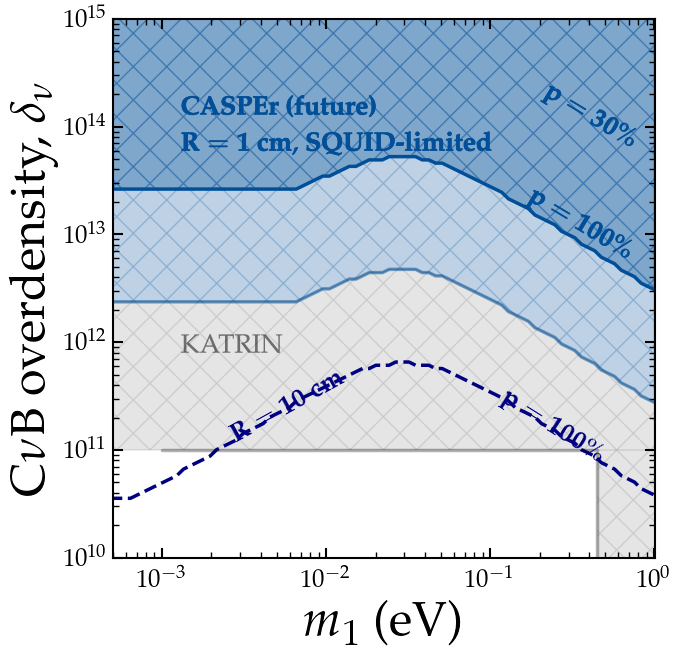

In [24]:
fig, ax = plt.subplots(figsize=(7,7))

c1 = '#004f98'
c2 = 'navy'

al = 0.05

f1 = (1000/0.1)**(3/2)*10*(0.3)**2  
f2 = (1000/0.1)**(3/2)*10      
f3 = (1000/0.1)**(1)*10  
f3 = (1000/0.1)**(1)*10  

si = 3

# mnl, dm  = np.loadtxt(main_dir+'/data/m_dep_v3.txt', unpack=True)
# mnl, dm1 = np.loadtxt(main_dir+'/data/m_dep_v3_r10.txt', unpack=True)

#dm = sn.gaussian_filter(dm, sigma=2)
dm = dell_m
dm0 = dell_m_0

plt.loglog(mnl, dm/f1, c=c1, lw=2.5)
plt.fill_between(mnl, dm/f1, 1e16*np.ones(len(mnl)), alpha=0.5, color=c1, hatch='X')

plt.loglog(mnl, dm/f2, c=c1, lw=2.5, alpha=0.5)
plt.fill_between(mnl, dm/f2, dm/f1, alpha=0.25, color=c1, hatch='X')

plt.loglog(mnl, dm0/f3, c=c2, lw=2.5, alpha=1, ls='--')

tc = plt.text(0.0013,1.3e14,r'{\bf CASPEr (future)}', fontsize=19, c=c1)
tc.set_path_effects([pe.Stroke(linewidth=0.5, foreground=c1),
                     pe.Normal()])

tc2 = plt.text(0.0013,6e13,r'${\bf R=1}$ {\bf cm}, {\bf SQUID-limited}', fontsize=19, c=c1)
tc2.set_path_effects([pe.Stroke(linewidth=0.5, foreground=c1),
                     pe.Normal()])

tp1 = plt.text(0.2, 6.5e13,r'${\bf p=30\%}$', fontsize=19,c=c1, alpha=1, rotation=-31)
tp2 = plt.text(0.16,6e12,r'${\bf p=100\%}$', fontsize=19,c=c1, alpha=1, rotation=-31)
tp1.set_path_effects([pe.Stroke(linewidth=0.5, foreground=c1),
                     pe.Normal()])
tp2.set_path_effects([pe.Stroke(linewidth=0.5, foreground=c1),
                     pe.Normal()])

# plt.loglog(mnl, dm_0/f4, c='crimson', lw=2, ls='--')
#plt.text(0.055,5.5e7,r'${\bf R=10}$ {\bf cm}', fontsize=17,c='crimson', rotation=0)
plt.text(0.0025, 1.2e11,r'${\bf R=10}$ {\bf cm}', fontsize=19,c=c2, rotation=29, alpha=1)
#plt.text(0.0013, 2e10,r'${\bf R=10}$ {\bf cm}', fontsize=19,c=c2, rotation=0, alpha=1)
tp2 = plt.text(0.11,8e10,r'${\bf p=100\%}$', fontsize=19,c=c2, alpha=1, rotation=-32)

mm = np.geomspace(1e-3, 2,100)
mm2 = np.geomspace(1e-3, 0.45,100)
plt.loglog(mm2, mm2/mm2*1e11, c='k', lw=2.5, alpha=0.3)
plt.fill_between(mnl, 1e11, dm/f2, alpha=0.1, color='k', hatch='X')

yy = np.geomspace(1e3,1e11,100)
plt.axvline(0.45, ymax = 0.195, c='k', lw=2.5, alpha=0.3, color='k')
plt.fill_betweenx(yy, 0.45, 2, color='k', alpha=0.1, lw=0.001, hatch='X')
tk = plt.text(1.3e-3, 8e11, 'KATRIN', fontsize=19, alpha=0.3, c='k', rotation=0)
# #tk = plt.text(6e-1, 1e10, 'KATRIN', fontsize=19, alpha=1, c='w', rotation=-90)
tk.set_path_effects([pe.Stroke(linewidth=0.1, foreground='k'),
                     pe.Normal()])

# text_box = AnchoredText(
#     fr"Normal hierarchy", 
#     loc='lower left',            
#     frameon=True,                
#     prop=dict(size=16)
# )
# ax.add_artist(text_box)

plt.xlabel(r'$m_1$ (eV)')
plt.ylabel(r'C$\nu$B overdensity, $\delta_{\nu}$')
plt.xlim(5e-4, 1.01)
plt.ylim(1e10, 1e15)
plt.show()
#fig.savefig(main_dir+'plots/deltanu_m1_v3.pdf', bbox_inches='tight')

In [ ]:
# def find_delta_Cho(
#         R,
#         mnu,
#         p_init=1,
#         sampf=14.3e3,
#         B=0.1,
#         T2=1,
#         T1ratio=100,
#         Nshots=100,
#         seed=42,
#         d_init=1e5,
#         d_fin=1e20,
#         ndelta=100,
#         chi2_crit=2.7,
#         squid_noise_ratio=0.0,
#         ncode=1e9,
#         Bmax=12,
#         mode='m1',
#         sample='Xe',
#         squeeze=1,
#         opt=True,
#         sigma_spn=False,
#         verb=False
#     ):
#     '''
#     Chi-squared analysis on normalized ⟨J_z⟩, starting from
#     equatorial product state assuming T1 >> T2.
#     Returns upper limit on delta at specified confidence level.
#     '''
#     import numpy as np
#     from functools import lru_cache
#     from scipy.linalg import cho_factor, cho_solve

#     if sample == 'Xe':
#         ns = 1.35e22
#         A = 129
#         Z = 54
#         gy = 11.78e6
#     elif sample == 'He':
#         ns = 3e22
#         A = 3
#         Z = 2
#         gy = 32.43e6
#     elif sample == 'H':
#         ns = 3e22
#         A = 1
#         Z = 1
#         gy = 42.58e6
#     else:
#         raise ValueError("Sample not valid, choose 'Xe', 'He' or 'H'!")
#     eVHz = 1 / 6.58e-16 # eV/Hz conversion
#     w0 = 2 * np.pi * gy * B / eVHz # eV
#     pnu = 5.3e-4*2*np.pi*8065 # cm^-1
#     N = ns * 4 * np.pi / 3 * R**3 # number of spins
#     fsup = max(1, 4*(pnu * R)**2) # coherent suppression factor
#     w0_i = w0
    
#     # --- Time grid ---
#     tf = T2
#     ti = 1 / sampf
#     n_times = int((tf - ti) * sampf)
#     #t_exp = np.geomspace(ti, tf, n_times)
#     t_exp = np.linspace(ti, tf, n_times)
    
#     # --- Gamma ratios ---
#     gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#     if verb:
#         print("At B=%.2f, I get w=%.3e"%(B, w0))
#         print("g+/g- = %.7f"%gratio)
#     # --- Optimal splitting and B-field limitations
#     if opt:
#         knu = 5.3e-4
#         m1 = mm[0]
#         w0_opt = knu/m1/R/(8065*2*np.pi)
#         if w0_opt < w0:
#             if verb:
#                 print("Warning: splitting too large, adjusting to optimal value!")
#         w0 = w0_opt
#         B_opt = w0_opt * eVHz / (2*np.pi * gy)
#         if B_opt > Bmax:
#             if verb:
#                 print("Optimal splitting needs too large B field, adjusting to Bmax!")
#             B = Bmax
#             w0 = 2 * np.pi * gy * B / eVHz
#         gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#         if verb:
#             print("Passed w=%.3e, optimal w=%.3e, used w=%.3e"%(w0_i, w0_opt, w0))
#             print("g+/g- = %.7f"%gratio)
#     if verb:
#         print("Max rate is Gamma_-= %.3e Hz"%(gm*N**2/fsup))
    
    
#     # --- Memoized model prediction for normalized ⟨J_z⟩ ---
#     @lru_cache(maxsize=64)
#     def get_model_jz(delta):
#         Ncode = int(ncode)
#         tmin_code = min(t_exp) * N * gm/fsup * delta
#         tmax_code = max(t_exp) * N * gm/fsup * delta
#         t, jz, sz = on.solve(
#             Ncode,
#             gp_ratio=gratio,
#             gd_ratio=Ncode,
#             p_init=p_init,
#             ti=tmin_code,
#             tf=tmax_code,
#             ntimes=n_times,
#             tlin=True
#         )
#         jz_norm = jz / (Ncode / 2)
#         sz_norm = sz/ ( Ncode**(1/2) / 2)
#         return t, np.abs(jz_norm), sz_norm
        
#     delta_list = np.geomspace(d_init, d_fin, ndelta)
#     chi2_min = np.inf
#     delta_best = None
#     delta_crit = None
#     chi2l = []
    
#     for delta in delta_list:
#         _, jz_pred, sz_pred = get_model_jz(delta)
#         if sigma_spn:
#             sz_pred = np.ones_like(sz_pred)
#         d = jz_pred #- Jz_mean_exp
#         norm_factor = N / 4.0
#         sigma = sz_pred / np.sqrt(norm_factor)
#         gamma_loc = 1.0/ T1ratio / T2
#         delta_t = np.abs(t_exp[:, np.newaxis] - t_exp[np.newaxis, :])
#         corr = np.exp(-gamma_loc * delta_t)
#         C = (sigma[:, np.newaxis] * sigma[np.newaxis, :] * corr) / squeeze ** 2
#         if squid_noise_ratio > 0.0:
#             noise_term = squid_noise_ratio / norm_factor
#             C += np.eye(n_times) * noise_term
#         chole = cho_factor(C)
#         x = cho_solve(chole, d)
#         chi2 = Nshots * np.dot(d, x)
#         chi2l.append(chi2)
#         if chi2 < chi2_min:
#             chi2_min = chi2
#             delta_best = delta
#         if delta_crit is None and chi2 - chi2_min > chi2_crit:
#             delta_crit = delta
#             break
#     if delta_crit is None:
#        print("No delta found within scan range for J_z")
#     return delta_crit, chi2l, chi2-chi2_min, w0

In [ ]:
# def find_delta_new2(
#         R,
#         mnu,
#         p_init=1,
#         sampf=14.3e3,
#         B=0.1,
#         T2=1,
#         T1ratio=100,
#         Nshots=100,
#         seed=42,
#         d_init=1e5,
#         d_fin=1e20,
#         ndelta=100,
#         chi2_crit=2.7,
#         squid_noise_ratio=0.0,
#         ncode=1e9,
#         Bmax=12,
#         mode='m1',
#         sample='Xe',
#         squeeze=1,
#         opt=True,
#         sigma_spn=False,
#         verb=False
#     ):
#     '''
#     Chi-squared analysis on normalized ⟨J_z⟩, starting from
#     equatorial product state assuming T1 >> T2.
#     Returns upper limit on delta at specified confidence level.
#     '''
#     if sample == 'Xe':
#         ns = 1.35e22
#         A = 129
#         Z = 54
#         gy = 11.78e6
#     elif sample == 'He':
#         ns = 3e22
#         A = 3
#         Z = 2
#         gy = 32.43e6
#     elif sample == 'H':
#         ns = 3e22
#         A = 1
#         Z = 1
#         gy = 42.58e6
#     else:
#         raise ValueError("Sample not valid, choose 'Xe', 'He' or 'H'!")
#     eVHz = 1 / 6.58e-16 # eV/Hz conversion
#     w0 = 2 * np.pi * gy * B / eVHz # eV
#     pnu = 5.3e-4*2*np.pi*8065 # cm^-1
#     N = ns * 4 * np.pi / 3 * R**3 # number of spins
#     fsup = max(1, 4*(pnu * R)**2) # coherent suppression factor
#     w0_i = w0
#     # --- Time grid ---
#     tf = T2
#     ti = 1 / sampf
#     n_times = int((tf - ti) * sampf)
#     t_exp = np.geomspace(ti, tf, n_times)
#     # --- Gamma ratios ---
#     gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#     if verb:
#         print("At B=%.2f, I get w=%.3e"%(B, w0))
#         print("g+/g- = %.7f"%gratio)
#     # --- Optimal splitting and B-field limitations
#     if opt:
#         knu = 5.3e-4
#         m1 = mm[0]
#         w0_opt = knu/m1/R/(8065*2*np.pi)
#         if w0_opt < w0:
#             if verb:
#                 print("Warning: splitting too large, adjusting to optimal value!")
#         w0 = w0_opt
#         B_opt = w0_opt * eVHz / (2*np.pi * gy)
#         if B_opt > Bmax:
#             if verb:
#                 print("Optimal splitting needs too large B field, adjusting to Bmax!")
#             B = Bmax
#             w0 = 2 * np.pi * gy * B / eVHz
#         gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#         if verb:
#             print("Passed w=%.3e, optimal w=%.3e, used w=%.3e"%(w0_i, w0_opt, w0))
#             print("g+/g- = %.7f"%gratio)
#     if verb:
#         print("Max rate is Gamma_-= %.3e Hz"%(gm*N**2/fsup))
#     # -- Data generation -------
#     np.random.seed(seed)
#     jz_true_mean = 0.0
#     jz_true_std = np.sqrt(N / 4)
#     Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
#     Jz_mean_exp = np.mean(Jz_samples, axis=1) / (N / 2)
#     # --- Memoized model prediction for normalized ⟨J_z⟩ ---
#     @lru_cache(maxsize=64)
#     def get_model_jz(delta):
#         Ncode = int(ncode)
#         tmin_code = min(t_exp) * N * gm/fsup * delta
#         tmax_code = max(t_exp) * N * gm/fsup * delta
#         t, jz, sz = on.solve(
#             Ncode,
#             gp_ratio=gratio,
#             gd_ratio=Ncode,
#             p_init=p_init,
#             ti=tmin_code,
#             tf=tmax_code,
#             ntimes=n_times
#         )
#         jz_norm = jz / (Ncode / 2)
#         sz_norm = sz/ ( Ncode**(1/2) / 2)
#         return t, np.abs(jz_norm), sz_norm
#     delta_list = np.geomspace(d_init, d_fin, ndelta)
#     chi2_min = np.inf
#     delta_best = None
#     delta_crit = None
#     chi2l = []
#     for delta in delta_list:
#         _, jz_pred, sz_pred = get_model_jz(delta)
#         if sigma_spn:
#             sz_pred = np.ones_like(sz_pred)
#         d = jz_pred - Jz_mean_exp
#         norm_factor = N / 4.0
#         sigma = sz_pred / np.sqrt(norm_factor)
#         gamma_loc = 1/ T1ratio / T2
#         delta_t = np.abs(t_exp[:, np.newaxis] - t_exp[np.newaxis, :])
#         corr = np.exp(-gamma_loc * delta_t)
#         C = (sigma[:, np.newaxis] * sigma[np.newaxis, :] * corr) / squeeze ** 2
#         if squid_noise_ratio > 0.0:
#             noise_term = squid_noise_ratio / norm_factor
#             C += np.eye(n_times) * noise_term
#         inv_C = np.linalg.inv(C)
#         chi2 = Nshots * np.dot(d, np.dot(inv_C, d))
#         chi2l.append(chi2)
#         if chi2 < chi2_min:
#             chi2_min = chi2
#             delta_best = delta
#         if delta_crit is None and chi2 - chi2_min > chi2_crit:
#             delta_crit = delta
#             break
#     if delta_crit is None:
#        print("No delta found within scan range for J_z")
#     return delta_crit, chi2l, chi2-chi2_min, w0

In [ ]:
# def find_delta_new(
#         R,
#         mnu,
#         p_init=1,
#         sampf=14.3e3,
#         B=0.1,
#         T2=1,
#         T1ratio=100,
#         Nshots=100,
#         seed=42,
#         d_init=1e5,
#         d_fin=1e20,
#         ndelta=100,
#         chi2_crit=2.7,
#         squid_noise_ratio=0.0,
#         ncode=1e9,
#         Bmax=12,
#         mode='m1',
#         sample='Xe',
#         squeeze=1,
#         opt=True,
#         sigma_spn=False,
#         verb=False
#     ):
#     '''
#     Chi-squared analysis on normalized ⟨J_z⟩, starting from
#     equatorial product state assuming T1 >> T2.
#     Returns upper limit on delta at specified confidence level.
#     '''
#     if sample == 'Xe':
#         ns = 1.35e22
#         A = 129
#         Z = 54
#         gy = 11.78e6
#     elif sample == 'He':
#         ns = 3e22
#         A = 3
#         Z = 2
#         gy = 32.43e6
#     elif sample == 'H':
#         ns = 3e22
#         A = 1
#         Z = 1
#         gy = 42.58e6
#     else:
#         raise ValueError("Sample not valid, choose 'Xe', 'He' or 'H'!")
#     eVHz = 1 / 6.58e-16 # eV/Hz conversion
#     w0 = 2 * np.pi * gy * B / eVHz # eV
#     pnu = 5.3e-4*2*np.pi*8065 # cm^-1
#     N = ns * 4 * np.pi / 3 * R**3 # number of spins
#     fsup = max(1, 4*(pnu * R)**2) # coherent suppression factor
#     w0_i = w0
#     # --- Time grid ---
#     tf = T2
#     ti = 1 / sampf
#     n_times = int((tf - ti) * sampf)
#     t_exp = np.geomspace(ti, tf, n_times)
#     # --- Gamma ratios ---
#     gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#     if verb:
#         print("At B=%.2f, I get w=%.3e"%(B, w0))
#         print("g+/g- = %.7f"%gratio)
#     # --- Optimal splitting and B-field limitations
#     if opt:
#         knu = 5.3e-4
#         m1 = mm[0]
#         w0_opt = knu/m1/R/(8065*2*np.pi)
#         if w0_opt < w0:
#             if verb:
#                 print("Warning: splitting too large, adjusting to optimal value!")
#         w0 = w0_opt
#         B_opt = w0_opt * eVHz / (2*np.pi * gy)
#         if B_opt > Bmax:
#             if verb:
#                 print("Optimal splitting needs too large B field, adjusting to Bmax!")
#             B = Bmax
#             w0 = 2 * np.pi * gy * B / eVHz
#         gratio, gm, mm = on.compute_ratio(mnu, w0, A=A, Z=Z, mode=mode)
#         if verb:
#             print("Passed w=%.3e, optimal w=%.3e, used w=%.3e"%(w0_i, w0_opt, w0))
#             print("g+/g- = %.7f"%gratio)
#     if verb:
#         print("Max rate is Gamma_-= %.3e Hz"%(gm*N**2/fsup))
#     # -- Data generation -------
#     np.random.seed(seed)
#     jz_true_mean = 0.0
#     jz_true_std = np.sqrt(N / 4)
#     Jz_samples = np.random.normal(jz_true_mean, jz_true_std, size=(n_times, Nshots))
#     Jz_mean_exp = np.mean(Jz_samples, axis=1) / (N / 2)
#     # --- Memoized model prediction for normalized ⟨J_z⟩ ---
#     @lru_cache(maxsize=64)
#     def get_model_jz(delta):
#         Ncode = int(ncode)
#         tmin_code = min(t_exp) * N * gm/fsup * delta
#         tmax_code = max(t_exp) * N * gm/fsup * delta
#         t, jz, sz = on.solve(
#             Ncode,
#             gp_ratio=gratio,
#             gd_ratio=Ncode,
#             p_init=p_init,
#             ti=tmin_code,
#             tf=tmax_code,
#             ntimes=n_times
#         )
#         jz_norm = jz / (Ncode / 2)
#         sz_norm = sz/ ( Ncode**(1/2) / 2)
#         return t, np.abs(jz_norm), sz_norm
#     delta_list = np.geomspace(d_init, d_fin, ndelta)
#     chi2_min = np.inf
#     delta_best = None
#     delta_crit = None
#     chi2l = []
#     for delta in delta_list:
#         _, jz_pred, sz_pred = get_model_jz(delta)
#         if sigma_spn:
#             sz_pred = np.ones_like(sz_pred)
#         d = jz_pred - Jz_mean_exp
#         norm_factor = N / 4.0
#         sigma = sz_pred / np.sqrt(norm_factor)
#         gamma_loc = 1/ T1ratio / T2
#         delta_t = np.abs(t_exp[:, np.newaxis] - t_exp[np.newaxis, :])
#         corr = np.exp(-gamma_loc * delta_t)
#         C = (sigma[:, np.newaxis] * sigma[np.newaxis, :]) * corr
#         if squid_noise_ratio > 0.0:
#             noise_term = squid_noise_ratio / norm_factor
#             C += np.eye(n_times) * noise_term
#         C /= squeeze ** 2
#         inv_C = np.linalg.inv(C)
#         chi2 = Nshots * np.dot(d, np.dot(inv_C, d))
#         chi2l.append(chi2)
#         if chi2 < chi2_min:
#             chi2_min = chi2
#             delta_best = delta
#         if delta_crit is None and chi2 - chi2_min > chi2_crit:
#             delta_crit = delta
#             break
#     if delta_crit is None:
#        print("No delta found within scan range for J_z")
#     return delta_crit, chi2l, chi2-chi2_min, w0